# EIA PV installs

This journal shows the path to obtain CdTe and c-Si market share projections based on eia860 data and the original PV install data from the notebook **(baseline development) PV Installations - US**.



---
## Import packages and files

Import [eia 860 data](https://www.eia.gov/electricity/data/eia860/) from 2021 to extract new PV all tech and c-Si US installs.

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 6)
cwd = os.getcwd()

In [2]:
cwd = os.getcwd() #grabs current working directory

supportMatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
baselinesFolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines')

Load eia 860 solar file.

In [3]:
eia860_raw = pd.read_excel(os.path.join(supportMatfolder, '3_3_Solar_Y2021.xlsx'), sheet_name='Operable', header=1)

---
### Market share correction df
I show below what is wrong with eia860_raw. In a nutshell there are instances where some nameplate capacities are shared between c-Si and CdTe, making me double count. Therefore I am going to split these. I explain the sources below!

#### First correction: Springerville 2001

Duplicate the problematic row:

In [4]:
eia860_raw[(eia860_raw['Operating Year'] == 2001) & (eia860_raw['Technology'] == 'Solar Photovoltaic') & (eia860_raw['Plant Name'] == 'Springerville')]

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Crystalline Silicon?,Thin-Film (CdTe)?,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW)
21,24211,Tucson Electric Power Co,8223,Springerville,AZ,Apache,SGSS,OP,Solar Photovoltaic,PV,...,Y,Y,NaN,NaN,NaN,NaN,N,,N,


In [5]:
index_num = eia860_raw[(eia860_raw['Operating Year'] == 2001) & (eia860_raw['Technology'] == 'Solar Photovoltaic') & (eia860_raw['Plant Name'] == 'Springerville')].index.values.astype(int)[0]
eia860_raw_correct_1 = pd.concat([eia860_raw, eia860_raw.iloc[[index_num]]*1],ignore_index=True)

In [6]:
row_si_num = eia860_raw_correct_1[(eia860_raw_correct_1['Operating Year'] == 2001) & (eia860_raw_correct_1['Technology'] == 'Solar Photovoltaic') & (eia860_raw_correct_1['Plant Name'] == 'Springerville')].index.values.astype(int)[0]
row_cdte_num = eia860_raw_correct_1[(eia860_raw_correct_1['Operating Year'] == 2001) & (eia860_raw_correct_1['Technology'] == 'Solar Photovoltaic') & (eia860_raw_correct_1['Plant Name'] == 'Springerville')].index.values.astype(int)[1]

Values replacement and correction

In [7]:
eia860_raw_correct_1.keys()

Index(['Utility ID', 'Utility Name', 'Plant Code', 'Plant Name', 'State',
       'County', 'Generator ID', 'Status', 'Technology', 'Prime Mover',
       'Sector Name', 'Sector', 'Nameplate Capacity (MW)',
       'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Operating Month',
       'Operating Year', 'Lenses / Mirrors?', 'Single-Axis Tracking?',
       'Dual-Axis Tracking?', 'Fixed Tilt?', 'East West Fixed Tilt?',
       'Parabolic Trough?', 'Linear Fresnel?', 'Power Tower?', 'Dish Engine?',
       'Other Solar Technology?', 'Azimuth Angle', 'Tilt Angle',
       'DC Net Capacity (MW)', 'Crystalline Silicon?', 'Thin-Film (CdTe)?',
       'Thin-Film (A-Si)?', 'Thin-Film (CIGS)?', 'Thin-Film (Other)?',
       'Other Materials?', 'Net Metering Agreement?',
       'Net Metering DC Capacity (MW)', 'Virtual Net Metering Agreement?',
       'Virtual Net Metering DC Capacity (MW)'],
      dtype='object')

In [8]:
eia860_raw_correct_1.loc[row_si_num, 'Thin-Film (CdTe)?'], eia860_raw_correct_1.loc[row_si_num, 'Nameplate Capacity (MW)'] = 'N', 2.7
eia860_raw_correct_1.loc[row_cdte_num, 'Crystalline Silicon?'], eia860_raw_correct_1.loc[row_cdte_num, 'Nameplate Capacity (MW)'] = 'N', 1

Check to see if I change the values:

In [20]:
eia860_raw_correct_1.loc[row_si_num]
#eia860_raw_correct_1.loc[row_cdte_num]

Utility ID                                                  24211
Utility Name                             Tucson Electric Power Co
Plant Code                                                   8223
Plant Name                                          Springerville
State                                                          AZ
County                                                     Apache
Generator ID                                                 SGSS
Status                                                         OP
Technology                                     Solar Photovoltaic
Prime Mover                                                    PV
Sector Name                                      Electric Utility
Sector                                                          1
Nameplate Capacity (MW)                                       2.7
Summer Capacity (MW)                                          3.7
Winter Capacity (MW)                                          3.7
Operating 

#### Correction 2: Solar Gen 2 Solar Facility

I am going to change the Solar Gen 2 Solar Facility to be only CdTe (more explenation at the end of this notebook).

In [11]:
index_list = eia860_raw[(eia860_raw['Plant Name'] == 'Solar Gen 2 Solar Facility')].index.values

In [12]:
eia860_raw_correct_1.loc[index_list, 'Crystalline Silicon?'] = 'N'
eia860_raw_correct_1.loc[index_list]

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Crystalline Silicon?,Thin-Film (CdTe)?,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW)
909,17650,Southern Power Co,58592,Solar Gen 2 Solar Facility,CA,Imperial,ALHM,OP,Solar Photovoltaic,PV,...,N,Y,NaN,NaN,NaN,NaN,N,,N,
910,17650,Southern Power Co,58592,Solar Gen 2 Solar Facility,CA,Imperial,ARK,OP,Solar Photovoltaic,PV,...,N,Y,NaN,NaN,NaN,NaN,N,,N,
911,17650,Southern Power Co,58592,Solar Gen 2 Solar Facility,CA,Imperial,SONR,OP,Solar Photovoltaic,PV,...,N,Y,NaN,NaN,NaN,NaN,N,,N,


#### Correction 3: Springbok 3 

There is no data on what kind Springbok 3 is. However, I can assume it is not CdTe because First Solar is not mentioned in their [website](https://avantus.com/development) nor in the [2019 First Solar annual report](https://s2.q4cdn.com/646275317/files/doc_financials/2019/ar/First-Solar-2019-Annual-Report-vPost.pdf).

In [21]:
index_3 = eia860_raw[(eia860_raw['Plant Name'] == 'Springbok 3 Solar Farm Hybrid')].index.values
index_3

array([2121])

In [22]:
eia860_raw_correct_1.loc[index_3, 'Thin-Film (CdTe)?'] = 'N'
eia860_raw_correct_1.loc[index_3]

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Crystalline Silicon?,Thin-Film (CdTe)?,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW)
2121,60278,64KT 8me LLC,60491,Springbok 3 Solar Farm Hybrid,CA,Kern,SB3SF,OP,Solar Photovoltaic,PV,...,Y,N,NaN,NaN,NaN,NaN,N,,N,


---
## Total PV

In [23]:
eia860_raw_pv = eia860_raw_correct_1[eia860_raw_correct_1['Technology'] == 'Solar Photovoltaic']
eia860_all_pv = eia860_raw_pv.groupby('Operating Year').sum()

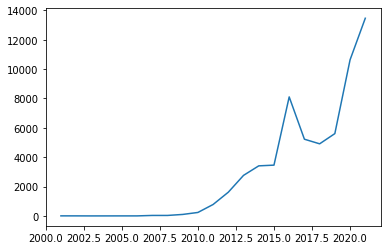

In [24]:
plt.plot(eia860_all_pv.index, eia860_all_pv['Nameplate Capacity (MW)'])
#plt.yscale('symlog')

There is no data between 1995 and 2001 so I will complete it with Heather's original PV install baseline. Also also, I believe the eia data is for utility scale only, so I will see the difference between Heather's and eia dataframes. Probably I will use Heather's since it includes residential, commercial and utility.

According to WoodMckenzie First Solar has a small percentage (~0.2 and 2%) of the commercial scale installs in 2021 and 2022. I need to check if we can share the actual values here.

Load the original PV installs data and drop the years from 2001.

In [25]:
us_installs_original = pd.read_csv(os.path.join(supportMatfolder,'output_USA_allPV_installs.csv'), index_col='Year')
us_installs_original.rename(columns={'installed_pv_MW':'Nameplate Capacity (MW)'},inplace=True)
us_installs_original_before_2001 = us_installs_original.loc[(us_installs_original.index<2001)]


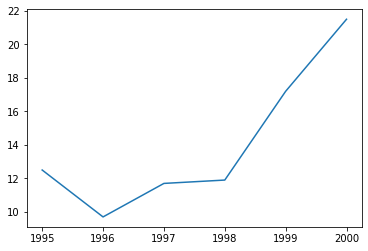

In [26]:
plt.plot(us_installs_original_before_2001.index, us_installs_original_before_2001['Nameplate Capacity (MW)'])


Now I concatenate both datasets, and boom... we get a new PV all tech installs line.

In [27]:
new_pv_installs = pd.concat([us_installs_original_before_2001, eia860_all_pv])

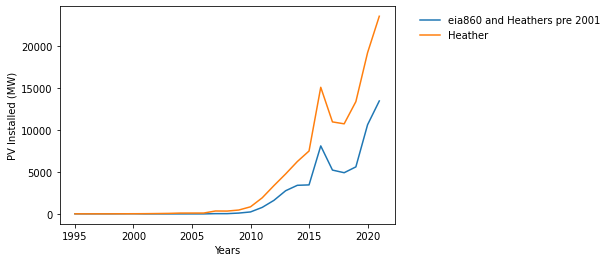

In [28]:
plt.plot(new_pv_installs.index, new_pv_installs['Nameplate Capacity (MW)'], label= 'eia860 and Heathers pre 2001')
plt.plot(us_installs_original.index, us_installs_original['Nameplate Capacity (MW)'], label= 'Heather')
plt.ylabel('PV Installed (MW)')
plt.xlabel('Years')
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')

Yes, the drop is huge. Therefore I will use the total PV installs from Heather to calculate the market shares since it represents more the total PV, not only utility.

In [ ]:
# Export to csv
new_pv_installs['Nameplate Capacity (MW)'].to_csv(os.path.join(supportMatfolder, 'output_eia860_all_pv.csv'))

---
## PV separated by tech installs and market share only for utility

Find cSi data and CdTe from the eia890 dataframe.

In [29]:
eia860_raw_cSi = eia860_raw_correct_1[eia860_raw_correct_1['Crystalline Silicon?'] == 'Y']
eia860_raw_CdTe = eia860_raw_correct_1[eia860_raw_correct_1['Thin-Film (CdTe)?'] == 'Y']
# eia860_raw_CIGS = eia860_raw[eia860_raw['Thin-Film (CIGS)?'] == 'Y']
# eia860_raw_ASi = eia860_raw[eia860_raw['Thin-Film (A-Si)?'] == 'Y']
# eia860_raw_Other = eia860_raw[eia860_raw['Thin-Film (Other)?'] == 'Y'] # Ignore 'other' because they are mixed with c-Si and it is not clear what it is

Group by year.

In [30]:
eia860_cSi = eia860_raw_cSi.groupby('Operating Year').sum()
eia860_CdTe = eia860_raw_CdTe.groupby('Operating Year').sum()
# eia860_CIGS = eia860_raw_CIGS.groupby('Operating Year').sum()
# eia860_ASi = eia860_raw_ASi.groupby('Operating Year').sum()
#eia860_Other = eia860_raw_Other.groupby('Operating Year').sum()


Concatenate cSi data pre-2001 since it was 100% c-Si.

In [31]:
eia860_cSi = pd.concat([us_installs_original_before_2001, eia860_cSi])


In [32]:
eia860_cSi.to_csv(os.path.join(supportMatfolder, 'output_eia860_c-Si_installs_utility.csv'))
eia860_CdTe.to_csv(os.path.join(supportMatfolder, 'output_eia860_CdTe_installs_utility.csv'))

Plot.

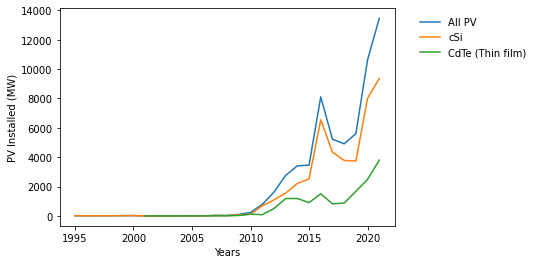

In [33]:
plt.plot(new_pv_installs.index, new_pv_installs['Nameplate Capacity (MW)'], label='All PV')
plt.plot(eia860_cSi.index, eia860_cSi['Nameplate Capacity (MW)'], label='cSi')
plt.plot(eia860_CdTe.index, eia860_CdTe['Nameplate Capacity (MW)'], label='CdTe (Thin film)')
# plt.plot(eia860_CIGS.index, eia860_CIGS['Nameplate Capacity (MW)'], label='CIGS (Thin film)')
# plt.plot(eia860_ASi.index, eia860_ASi['Nameplate Capacity (MW)'], label='A-Si (Thin film)')
#plt.plot(eia860_Other.index, eia860_Other['Nameplate Capacity (MW)'], label='Other (Thin film)')

plt.ylabel('PV Installed (MW)')
plt.xlabel('Years')
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.plot(df_installs_raw, marker='o')

### Market share calculations - utility

In [34]:
ms_utility = pd.DataFrame()
ms_utility['c-Si (%)'] = eia860_cSi['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
ms_utility['CdTe (%)'] = eia860_CdTe['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
# ms['CIGS (Thin film)'] = eia860_CIGS['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
# ms['A-Si (Thin film)'] = eia860_ASi['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
#ms['Other (Thin film)'] = eia860_Other['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
ms_utility.fillna(0, inplace=True)
ms_utility = ms_utility.round(4)
ms_utility.to_csv(os.path.join(supportMatfolder, 'output_eia860_market_share_c-Si_CdTe_utility.csv'))

In [35]:
ms_utility

,c-Si (%),CdTe (%)
1995,1.0000,0.0000
1996,1.0000,0.0000
1997,1.0000,0.0000
1998,1.0000,0.0000
1999,1.0000,0.0000
2000,1.0000,0.0000
2001,0.7436,0.2564
2002,1.0000,0.0000
2003,1.0000,0.0000
2005,1.0000,0.0000


Tidy data version

In [36]:
ms_utility.reset_index(inplace=True)
ms_utility = ms_utility.rename(columns={'index': 'Year'})
tidy_ms_utility = ms_utility.melt('Year', var_name='Technology', value_name='Market share')
tidy_ms_utility.to_csv(os.path.join(supportMatfolder, 'output_eia860_tidy_cSi_CdTe_market_share_utility.csv'))

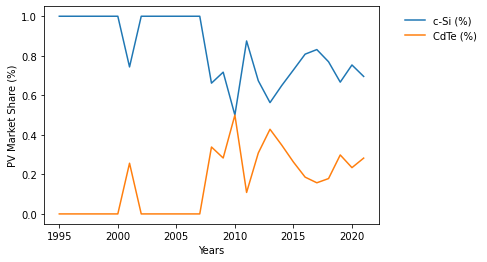

In [37]:
ax = sns.lineplot(x='Year', y='Market share', data=tidy_ms_utility, hue='Technology')
#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x))) # Sets year x axis as 
#ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.ylabel('PV Market Share (%)')
plt.xlabel('Years')
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.plot(df_installs_raw, marker='o')

## PV separated by tech installs and market share with all installs.

In this version, I use Heather's original data for all PV and c-Si fraction since it comprises residential, commercial and CdTe. CdTe is virtually only utility scale.

In [38]:
heather_csi_data = pd.read_csv(os.path.join(supportMatfolder,'output_USA_SiPV_installs.csv'), index_col='Year')
heather_csi_data.rename(columns={'0': 'Nameplate Capacity (MW)'}, inplace=True)

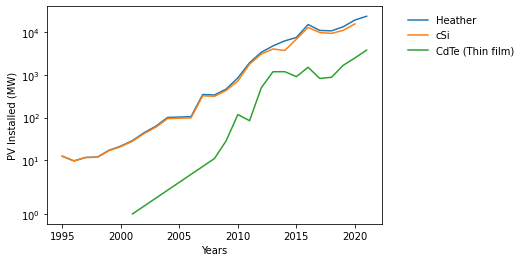

In [39]:
plt.plot(us_installs_original.index, us_installs_original['Nameplate Capacity (MW)'], label= 'Heather')
plt.plot(heather_csi_data.index, heather_csi_data['Nameplate Capacity (MW)'], label='cSi')
plt.plot(eia860_CdTe.index, eia860_CdTe['Nameplate Capacity (MW)'], label='CdTe (Thin film)')
plt.ylabel('PV Installed (MW)')
plt.xlabel('Years')
plt.yscale('symlog') # Comment this one if you want to see it at normal scale
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.plot(df_installs_raw, marker='o')


This one shows a more realistic scenario. Let's now calculate market share.

In [47]:
ms_all = pd.DataFrame()
ms_all['c-Si'] = heather_csi_data['Nameplate Capacity (MW)']/us_installs_original['Nameplate Capacity (MW)']
ms_all['CdTe (Thin film)'] = eia860_CdTe['Nameplate Capacity (MW)']/us_installs_original['Nameplate Capacity (MW)']
# ms['CIGS (Thin film)'] = eia860_CIGS['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
# ms['A-Si (Thin film)'] = eia860_ASi['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
#ms['Other (Thin film)'] = eia860_Other['Nameplate Capacity (MW)']/new_pv_installs['Nameplate Capacity (MW)']
ms_all.fillna(0, inplace=True)
ms_all = ms_all.round(2)
ms_all.to_csv(os.path.join(supportMatfolder, 'output_eia860_market_share_c-Si_CdTe_all.csv'))

In [46]:
ms_all['add'] = ms_all['c-Si'] + ms_all['CdTe (Thin film)']
ms_all

,c-Si,CdTe (Thin film),add
Year,,,
1995,1.00,0.00,1.00
1996,1.00,0.00,1.00
1997,0.99,0.00,0.99
1998,0.99,0.00,0.99
1999,0.98,0.00,0.98
2000,0.97,0.00,0.97
2001,0.96,0.03,0.99
2002,0.96,0.00,0.96
2003,0.95,0.00,0.95


In [ ]:
ms_all.reset_index(inplace=True)
ms_all = ms_all.rename(columns={'index': 'Year'})
tidy_ms_all = ms_all.melt('Year', var_name='Technology', value_name='Market share')
tidy_ms_all.to_csv(os.path.join(supportMatfolder, 'output_eia860_tidy_cSi_CdTe_market_share_all.csv'))

In [ ]:
ax = sns.lineplot(x='Year', y='Market share', data=tidy_ms_all, hue='Technology')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x))) # Sets year x axis as 
ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.ylabel('PV Market Share')
plt.xlabel('Years')
#plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.plot(df_installs_raw, marker='o')

## PV installs projection for final cSi and CdTe installs

Here I base the projections on the Electrification Futures scenario.

Upload Electrification Futures baseline.

In [ ]:
ef_baseline = pd.read_csv(os.path.join(baselinesFolder,'output_USA_SiPV_installs.csv'), index_col='Year')


---
## Appendix: Market share correction

That moment in 2001 indicates that there is something odd in the eia data. Going back to the original excel, I can see that some values are marked as both, c-Si and CdTe so I am accidentally double counting. I found these conflicting years, and what I will do is to find the real values and also source them from Heather's original PV baselines.

Now let's look at the conflicting years that share CdTe and PV.

In [ ]:
eia860_raw[(eia860_raw['Crystalline Silicon?'] == 'Y') & (eia860_raw['Thin-Film (CdTe)?'] == 'Y')][['Operating Year', 'Nameplate Capacity (MW)', 'Plant Name', 'Crystalline Silicon?', 'Thin-Film (CdTe)?']]

There are also repeated c-Si with CIGS, A-Si and 'other materials'. I am going to ignore these since their contribution to the overall capacity is almost neglectable.

Doing some research, it appears that the 2001 plant Springerville had indeed both, CdTe and c-Si. From [this paper](https://www.sciencedirect.com/science/article/pii/S1473832503010046): 3.5 MW DC of crystalline silicon and thin-film modules. The Springerville site has over 1 MW of thin-film. It is a lower number than the eia. According to this, I split that 3.7 MW and assume 2.7 MW of c-Si and 1 MW of CdTe.

Solar Gen 2 Solar Facility is [solely CdTe](https://www.southernpowercompany.com/content/dam/southernpower/pdfs/fact-sheets/SolarGEN2_Solar_Facility_factsheet.pdf) with 163 MW of more than 1 million First Solar modules. I don't know why they split it in three (54.4 x 3 = 163.2), this checks out so I will jsut convert these three into a three that are only CdTe (i.e. I change Silicon to 'N'). Luckily Solar Gen 2 has the data only in 2014. This should be easy to fix :).

Lastly, I have not able to find anything about Springbok 3 Solar Farm Hybrid. If it was using CdTe probably First Solar would have announced it in one of their reports. Therefore I am going to assume that that 90 MW is solely c-Si.